# Data set processing

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn import neighbors
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('./dataset/suicide_rates_socioeconomic_factors.csv')

data = data.dropna()
data = data.apply(lambda x: pd.to_numeric(x, errors='ignore') if x.dtype == 'object' else x)


df = pd.DataFrame({'Year': data['Year'],
                    'RegionName': data['RegionName'],
                    'RegionCode':  data['RegionCode'],
                    'CountryName': data['CountryName'],
                    'CountryCode': data['CountryCode'],
                    'Sex': data['Sex'],
                    'SuicideCount': data['SuicideCount'],
                    'Population': data['Population'],
                    'GDPPerCapita': data['GDPPerCapita'],
                    'GNIPerCapita': data['GNIPerCapita'],
                    'EmploymentPopulationRatio': data['EmploymentPopulationRatio'],
                    'InflationRate': data['InflationRate']})

df = df.sort_values(by='Year')
df = df.reset_index(drop=True)
df.index = df.index + 1

display(df)

# convert categorical data to numerical using LabelEncoder
label_encoders = {}
for column in ['RegionCode', 'RegionName', 'CountryCode', 'CountryName', 'Sex']:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column].astype(str))
    label_encoders[column] = le

# features and target variable
X = data[['CountryCode', 'Year', 'Sex', 'GDPPerCapita', 'GNIPerCapita', 'InflationRate', 'EmploymentPopulationRatio']]
y = data['SuicideCount']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

C:\Users\izabela\AppData\Local\Temp\ipykernel_16336\1203070948.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
C:\Users\izabela\AppData\Local\Temp\ipykernel_16336\1203070948.py:11: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  data = data.apply(lambda x: pd.to_numeric(x, errors='ignore') if x.dtype == 'object' else x)


,Year,RegionName,RegionCode,CountryName,CountryCode,Sex,SuicideCount,Population,GDPPerCapita,GNIPerCapita,EmploymentPopulationRatio,InflationRate
1,1991,Europe,EU,Belgium,BEL,Male,1278,10004486.0,21041.66065,19740.0,45.831,3.215311
2,1991,Oceania,OA,Australia,AUS,Female,482,17284036.0,18859.40796,17120.0,57.094,3.176675
3,1991,Oceania,OA,Australia,AUS,Male,1806,17284036.0,18859.40796,17120.0,57.094,3.176675
4,1991,Europe,EU,Spain,ESP,Female,777,38966376.0,14811.90282,14310.0,41.664,5.934213
5,1991,Europe,EU,Austria,AUT,Male,1299,7754891.0,22410.91177,20600.0,53.930,3.337427
...,...,...,...,...,...,...,...,...,...,...,...,...
4694,2022,Europe,EU,Sweden,SWE,Male,898,10486941.0,56424.28470,67630.0,61.343,8.369291
4695,2022,Europe,EU,Estonia,EST,Male,147,1348840.0,28247.09599,45200.0,61.512,19.398263
4696,2022,Europe,EU,Estonia,EST,Female,46,1348840.0,28247.09599,45200.0,61.512,19.398263
4697,2022,Asia,AS,Singapore,SGP,Male,237,5637022.0,82807.62906,107070.0,68.694,6.121060


# KNN prediction

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

knn = neighbors.KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm = 'kd_tree')
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='kd_tree', weights='distance')

In [94]:
# prediction function
def predict_suicides(country, year, sex):
    country_code = label_encoders['CountryCode'].transform([country])[0]
    sex_code = label_encoders['Sex'].transform([sex])[0]
    input_data = [[country_code, year, sex_code, 0, 0, 0, 0]]  # Default socio-economic factors to 0 for simplicity
    input_data_scaled = scaler.transform(input_data)
    prediction = knn.predict(input_data_scaled)
    return prediction[0]

In [95]:
# Example prediction for France year 2023
country = 'FRA'
year = 2023
predicted_suicides_male = predict_suicides(country, year, 'Male')
predicted_suicides_female = predict_suicides(country, year, 'Female')

print(f"In {year}, in {country}, there will be an average number of {predicted_suicides_male:.2f} suicides for men and {predicted_suicides_female:.2f} suicides for women.")


In 2023, in FRA, there will be an average number of 10.00 suicides for men and 2.00 suicides for women.


c:\Users\izabela\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\izabela\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


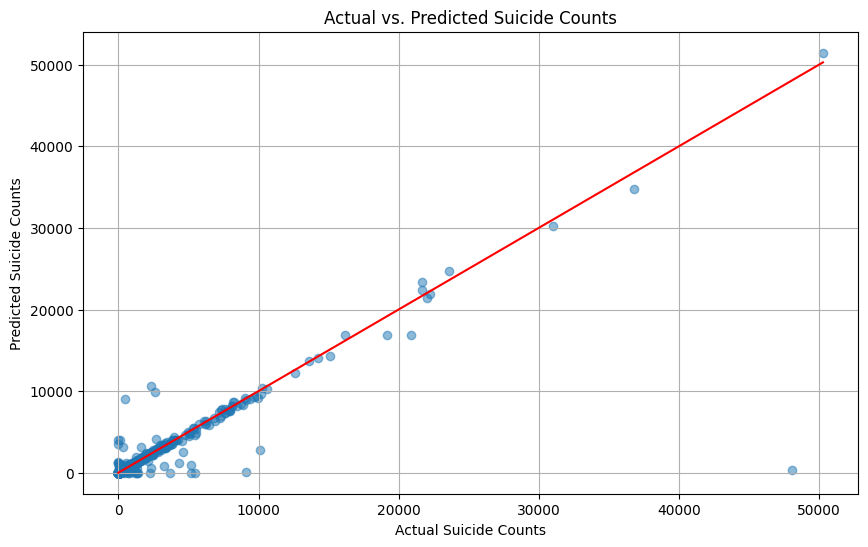

In [96]:
# 1. Scatter Plot of Actual vs. Predicted Suicides
y_pred = knn.predict(X_test)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Suicide Counts')
plt.ylabel('Predicted Suicide Counts')
plt.title('Actual vs. Predicted Suicide Counts')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.grid(True)
plt.show()


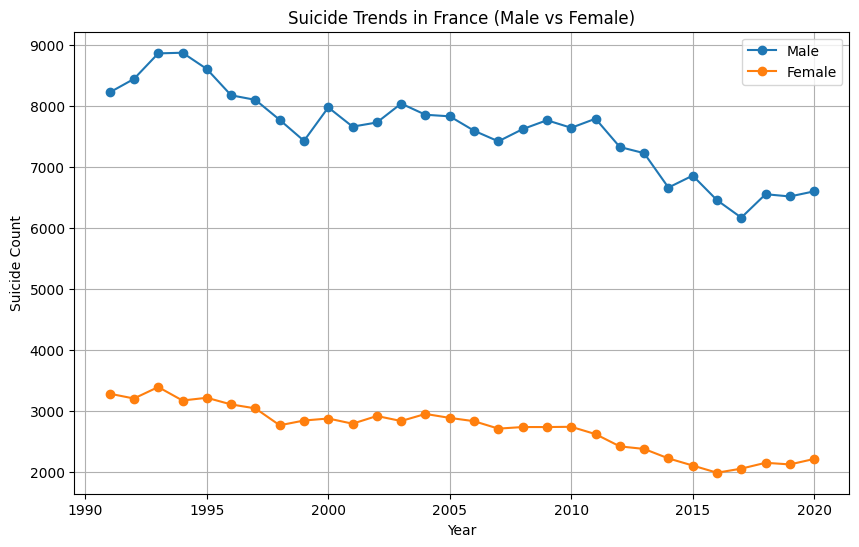

In [97]:
# 2. Trend of Suicides Over Years for France
france_data = data[data['CountryCode'] == label_encoders['CountryCode'].transform(['FRA'])[0]]
france_data_male = france_data[france_data['Sex'] == label_encoders['Sex'].transform(['Male'])[0]]
france_data_female = france_data[france_data['Sex'] == label_encoders['Sex'].transform(['Female'])[0]]

plt.figure(figsize=(10, 6))
plt.plot(france_data_male['Year'], france_data_male['SuicideCount'], label='Male', marker='o')
plt.plot(france_data_female['Year'], france_data_female['SuicideCount'], label='Female', marker='o')
plt.xlabel('Year')
plt.ylabel('Suicide Count')
plt.title('Suicide Trends in France (Male vs Female)')
plt.legend()
plt.grid(True)
plt.show()

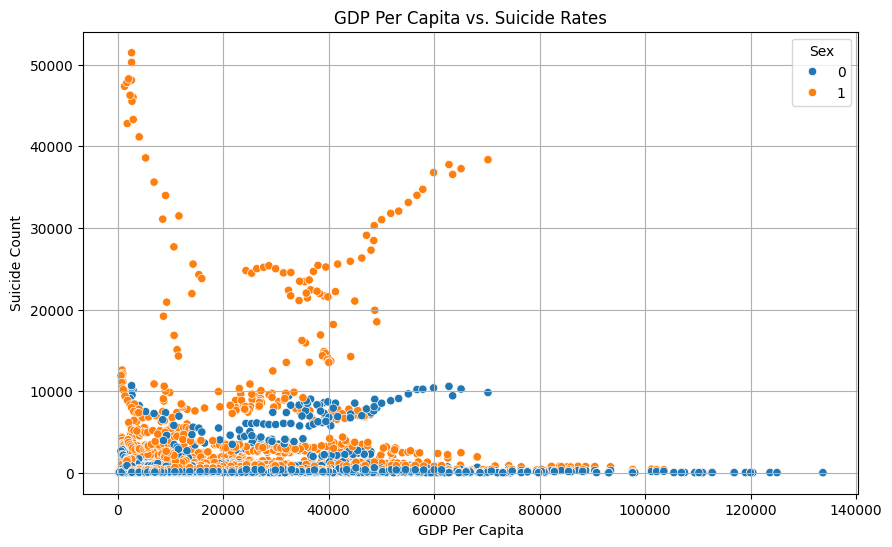

In [98]:
# 3. GDP Per Capita vs. Suicide Rates
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data['GDPPerCapita'], y=data['SuicideCount'], hue=data['Sex'])
plt.xlabel('GDP Per Capita')
plt.ylabel('Suicide Count')
plt.title('GDP Per Capita vs. Suicide Rates')
plt.grid(True)
plt.show()

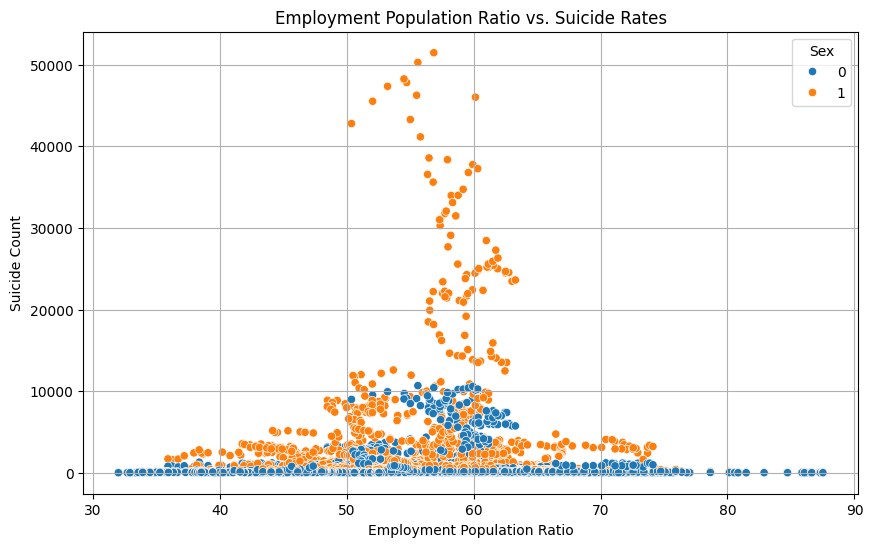

In [99]:
# 4. Employment Population Ratio vs. Suicide Rates
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data['EmploymentPopulationRatio'], y=data['SuicideCount'], hue=data['Sex'])
plt.xlabel('Employment Population Ratio')
plt.ylabel('Suicide Count')
plt.title('Employment Population Ratio vs. Suicide Rates')
plt.grid(True)
plt.show()

# Kmeans clustering

In [100]:
#kmeans
from sklearn.cluster import KMeans

# Selecting features for clustering
X = data[['CountryCode', 'Year', 'Sex', 'GDPPerCapita', 'GNIPerCapita', 'InflationRate', 'EmploymentPopulationRatio', 'SuicideCount']]

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [39]:
# Apply K-Means Clustering
kmeans = KMeans(n_clusters=5, random_state=42)  # Let's assume we want to find 5 clusters
data['Cluster'] = kmeans.fit_predict(X_scaled)

# Add the cluster labels back to the original data
data['Cluster'] = kmeans.labels_


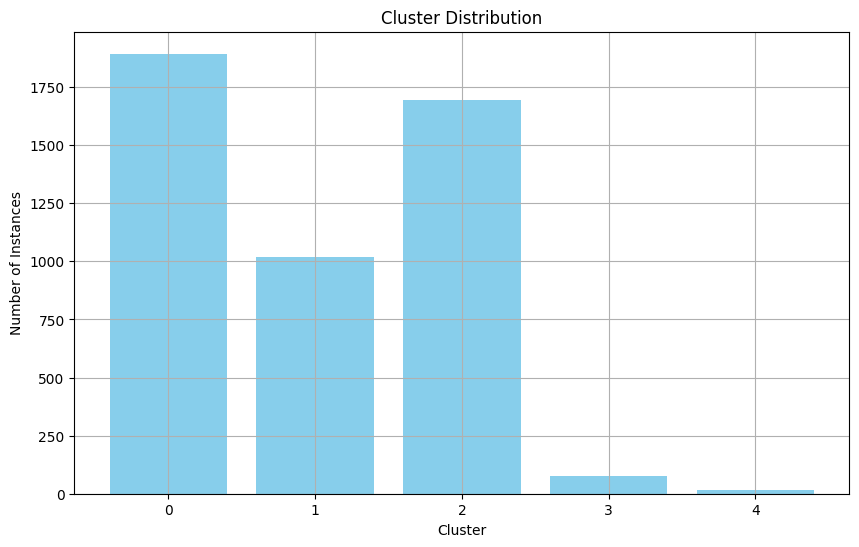

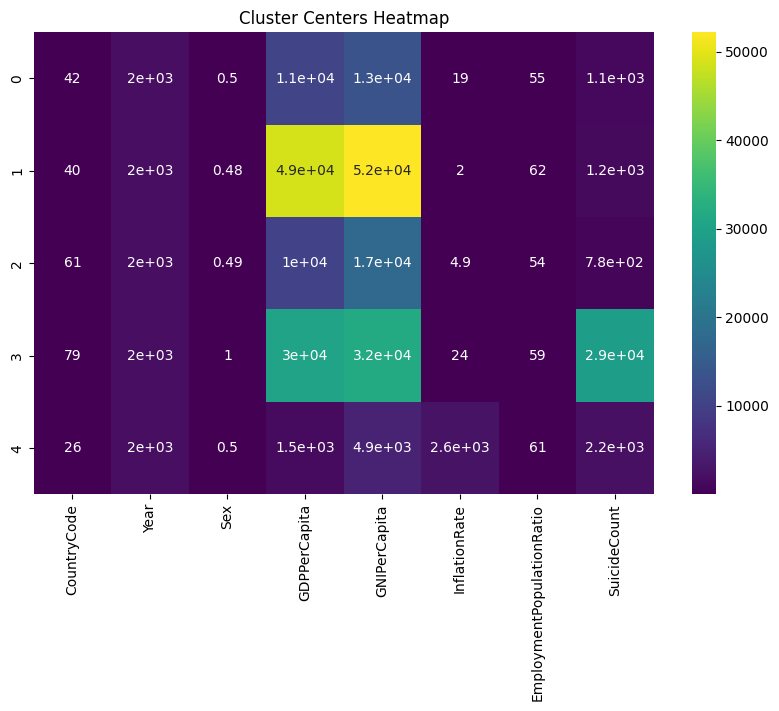

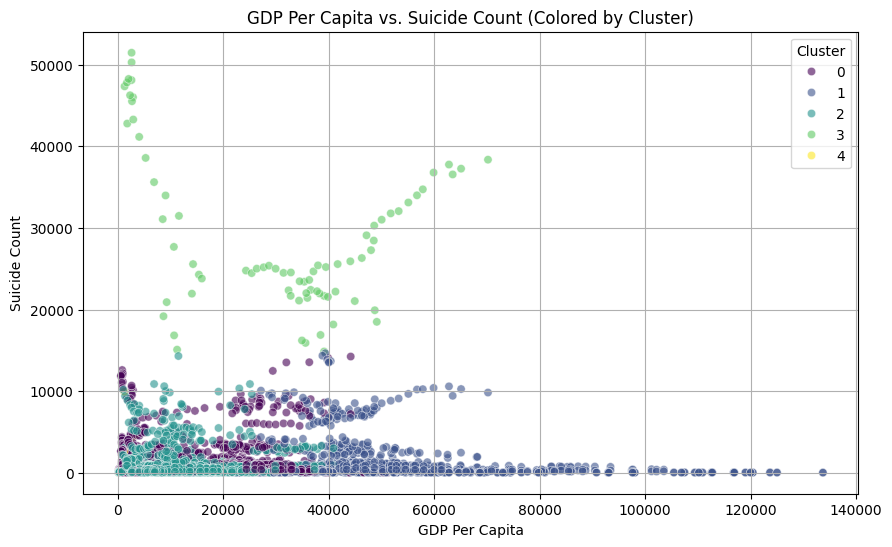

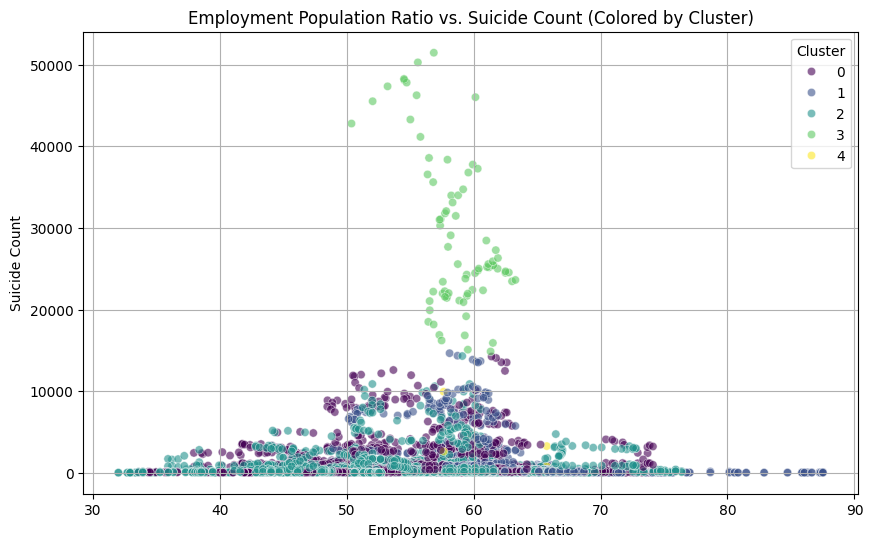

In [40]:
# 1. Cluster Distribution
plt.figure(figsize=(10, 6))
cluster_counts = data['Cluster'].value_counts().sort_index()
plt.bar(cluster_counts.index, cluster_counts.values, color='skyblue')
plt.xlabel('Cluster')
plt.ylabel('Number of Instances')
plt.title('Cluster Distribution')
plt.xticks(cluster_counts.index)
plt.grid(True)
plt.show()

# 2. Cluster Centers Heatmap
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
cluster_centers_df = pd.DataFrame(cluster_centers, columns=X.columns)
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_centers_df, annot=True, cmap='viridis')
plt.title('Cluster Centers Heatmap')
plt.show()

# 3. Scatter Plot of Clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data['GDPPerCapita'], y=data['SuicideCount'], hue=data['Cluster'], palette='viridis', alpha=0.6)
plt.xlabel('GDP Per Capita')
plt.ylabel('Suicide Count')
plt.title('GDP Per Capita vs. Suicide Count (Colored by Cluster)')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x=data['EmploymentPopulationRatio'], y=data['SuicideCount'], hue=data['Cluster'], palette='viridis', alpha=0.6)
plt.xlabel('Employment Population Ratio')
plt.ylabel('Suicide Count')
plt.title('Employment Population Ratio vs. Suicide Count (Colored by Cluster)')
plt.grid(True)
plt.show()


# PCA (with the data that was preprocessed at the Kmeans step)

In [103]:
from sklearn.decomposition import PCA

# Apply PCA to reduce the dataset to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame with the PCA results
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['Cluster'] = data['Cluster']


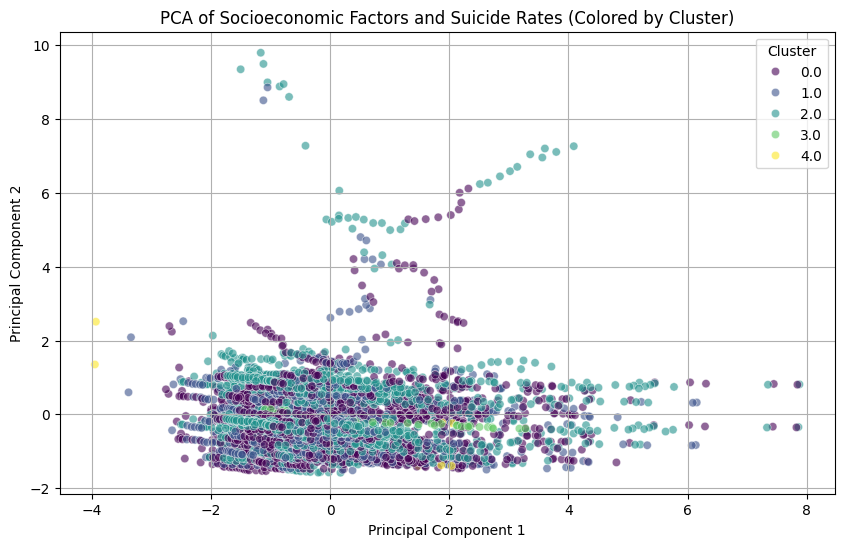

In [104]:
# Scatter Plot of PCA Results
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='viridis', alpha=0.6)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Socioeconomic Factors and Suicide Rates (Colored by Cluster)')
plt.grid(True)
plt.show()


Explained variance ratio of the first two principal components: [0.28242985 0.1543873 ]


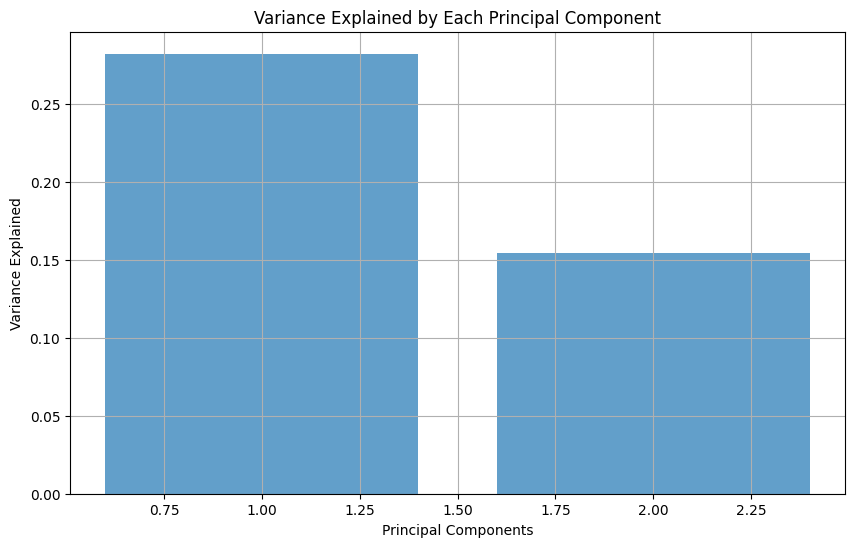

In [105]:
# Explained Variance Ratio
explained_variance_ratio = pca.explained_variance_ratio_
print(f"Explained variance ratio of the first two principal components: {explained_variance_ratio}")

# Bar plot of explained variance
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.7, align='center')
plt.xlabel('Principal Components')
plt.ylabel('Variance Explained')
plt.title('Variance Explained by Each Principal Component')
plt.grid(True)
plt.show()


# Information Retrieval

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('./dataset/suicide_rates_socioeconomic_factors.csv')

data = data.dropna()

# Convert columns to numeric, catching exceptions explicitly
for column in data.columns:
    if data[column].dtype == 'object':
        try:
            data[column] = pd.to_numeric(data[column])
        except ValueError:
            pass 

# Sort countries by 'SuicideCount' (descending order)
sorted_indices = np.argsort(data['SuicideCount'].values)[::-1]

# Filter relevant indices based on 'RegionCode' being 'EU'
relevant_idx = np.where(data['RegionCode'] == 'EU')[0]

In [4]:
def precision_recall_at_k(k):
    top_k_indices = sorted_indices[:k] 
    top_k_relevant = np.sum(np.isin(top_k_indices, relevant_idx))
    precision = top_k_relevant / k  
    if len(relevant_idx) > 0:
        recall = top_k_relevant / len(relevant_idx) 
    else:
        recall = 0.0
    return precision, recall

In [5]:
def f1_score(precision, recall):
    if precision + recall == 0:
        return 0.0
    return 2 * precision * recall / (precision + recall)

In [6]:
# Calculate precision, recall, and F1-score at different values of k
ks = range(1, len(data) + 1)
precisions = []
recalls = []
f1_scores = []

for k in ks:
    precision, recall = precision_recall_at_k(k)
    f1 = f1_score(precision, recall)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    
    print(f"At k={k}: Precision={precision:.4f}, Recall={recall:.4f}, F1-score={f1:.4f}")

At k=1: Precision=1.0000, Recall=0.0005, F1-score=0.0010
At k=2: Precision=1.0000, Recall=0.0010, F1-score=0.0020
At k=3: Precision=1.0000, Recall=0.0015, F1-score=0.0030
At k=4: Precision=1.0000, Recall=0.0020, F1-score=0.0040
At k=5: Precision=1.0000, Recall=0.0025, F1-score=0.0049
At k=6: Precision=1.0000, Recall=0.0030, F1-score=0.0059
At k=7: Precision=1.0000, Recall=0.0035, F1-score=0.0069
At k=8: Precision=1.0000, Recall=0.0040, F1-score=0.0079
At k=9: Precision=1.0000, Recall=0.0045, F1-score=0.0089
At k=10: Precision=1.0000, Recall=0.0050, F1-score=0.0099
At k=11: Precision=1.0000, Recall=0.0054, F1-score=0.0108
At k=12: Precision=1.0000, Recall=0.0059, F1-score=0.0118
At k=13: Precision=1.0000, Recall=0.0064, F1-score=0.0128
At k=14: Precision=0.9286, Recall=0.0064, F1-score=0.0128
At k=15: Precision=0.8667, Recall=0.0064, F1-score=0.0128
At k=16: Precision=0.8125, Recall=0.0064, F1-score=0.0128
At k=17: Precision=0.7647, Recall=0.0064, F1-score=0.0128
At k=18: Precision=0.72

In [7]:
def average_precision(precisions, recalls):
    ap = 0
    for k in range(1, len(precisions)):
        ap += precisions[k] * (recalls[k] - recalls[k - 1])
    return ap

ap = average_precision(precisions, recalls)

print("\nAverage Precision (AP):", ap)



Average Precision (AP): 0.523080133492963


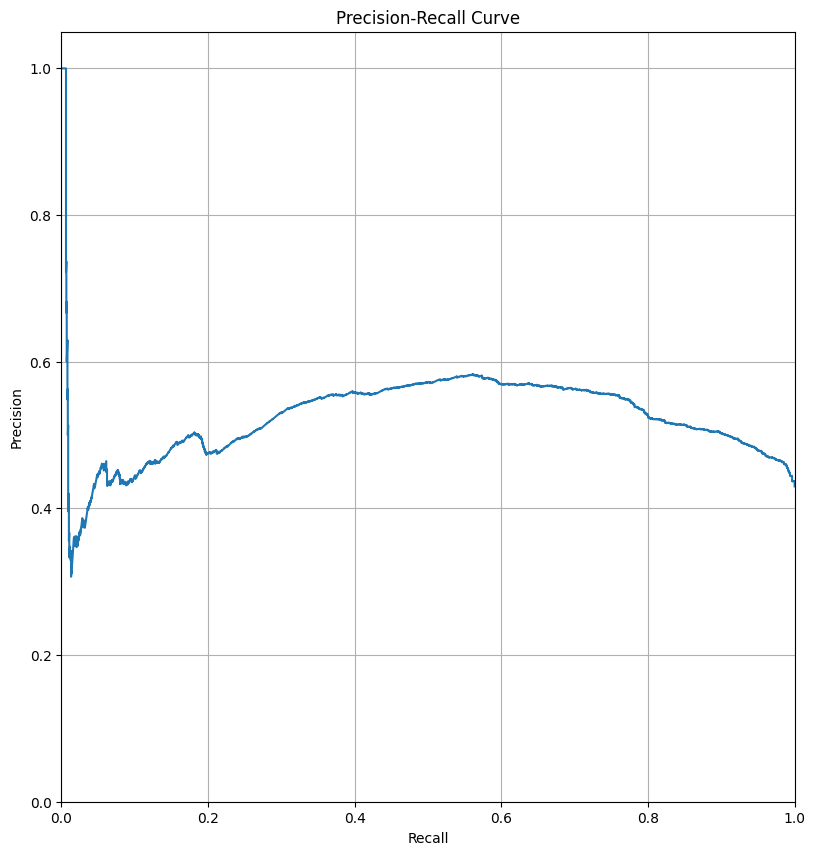

In [10]:
# Plot precision-recall curve
plt.figure(figsize=(10, 10))
plt.plot(recalls, precisions, linestyle='-')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.gca().set_aspect('equal', adjustable='box')
plt.show()
